# Create cloud optimized geotiff (COG) of ECCOv4r4 sea surface height (SSH) change

This notebook calculates SSH change from ECCOv4r4 data by reading the data directly from the PO.DAAC S3 data bucket on AWS us-west-2 region while working from a JupyterHub environment also located on us-west-2. 

Credit to Mike Croteau, who figured out the Earthdata authentication required to read directly from PO.DAAC S3 and very clearly documented the details in this notebook.

### Configuring Earthdata Authentication

You will need to setup Earthdata authentication to successfully use the PO.DAAC S3 bucket. A set of functions are included below to facilitate this (compiled from multiple sources, listed below). You can automate authentication by creating a ".netrc" file in your home directory and writing the following:

```
machine urs.earthdata.nasa.gov
    login <earthdata username>
    password <earthdata password>
```

On the JupyterHub, it is recommended that you do this from a terminal. First make sure you are in your home directory (`cd ~`), then create a new file and include the following:

```
cat >> .netrc
machine urs.earthdata.nasa.gov
    login <username>
    password <password>

```

Press `Enter` and then type `Ctrl+C` to save and close the prompt.

> **⚠️ Warning:** After writing the file, we _**strongly**_ recommend setting the new `.netrc` file to read-only for only the user using `chmod 0400 .netrc`. If you later need to edit this file, you can temporarily allow read/write by only the user with `chmod 0600 .netrc`. **NOTE:** Some users have found that they must reset the 0400 permissions every time they start a new server. If you find this to be the case, you can simply add the correct command to your bash profile or else run the first cell in this notebook. Alternatively, you may wish to forego using a .netrc file altogether and instead use the login prompt below to authenticate each time you use this notebook. _However, that prompt appears to be broken at this time..._

If configured successfully, you should see the following output from the second notebook cell.

```
# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.
```

Otherwise, you will see a message saying it could not use the .netrc file and it will ask you to input your username and password.

```
There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: 
```

---

*Note: There is a pip package called "earthdata" that is supposed to help with this process, primarily in reducing code that we must write. However, we have not been able to get it to install on the JupyterHub.*

---

Sources:

- [Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud](https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Estuary_explore_inCloud_zarr.ipynb)
- [SWOT Oceanography with PO.DAAC](https://git.mysmce.com/eis-sealevel/swot/-/blob/main/tutorials/.ipynb_checkpoints/SWOT_simulated_L2_SSH_introduction-checkpoint.ipynb)
- ["Update cloud_direct_access_s3.py" - podaac tutorials commit 4da70c7cf079ddd7a6de4c4345749f580ba66d71](https://github.com/podaac/tutorials/commit/4da70c7cf079ddd7a6de4c4345749f580ba66d71#)

In [1]:
!chmod 0400 ~/.netrc

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import progressbar

In [3]:
from urllib import request
from http.cookiejar import CookieJar
import netrc
import requests
import s3fs
import getpass

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.
    Valid endpoints:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        print('# Your URS credentials were securely retrieved from your .netrc file.')
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print("There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...")
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass.getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
def begin_s3_direct_access():
    url="https://archive.podaac.earthdata.nasa.gov/s3credentials"
    r = requests.get(url)
    response = r.json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],secret=response['secretAccessKey'],token=response['sessionToken'],client_kwargs={'region_name':'us-west-2'})

edl = "urs.earthdata.nasa.gov"
setup_earthdata_login_auth(edl)
print('Earthdata login credentials configured. Ready.')

# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.


## ECCO information and notes
Slides with info about the different ECCO versions:
https://events.ecmwf.int/event/199/contributions/1956/attachments/1109/2066/OceanDA21_Fenty.pdf

ECCOv4r4 data is here: https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4
* This is hosted in Earthdata cloud

ECCOv5 data is here: https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha
* This is not hosted in the cloud and must be downloaded


Helpful (potentially) resources and tutorials:
* https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial
* https://github.com/sea-level-change


## Initial check -- initiate S3 access and load one ECCO dataset

Here, we initiate S3 access, then use s3fs to tell us what netcdf files are available in the given S3 bucket (printing out the last 5 for good measure). Then we select the last file and load it using xarray. Alternatively, you could attempt to use "harmony" to convert it to zarr format and load things from there (see the first source document above for more details).

In [4]:
# Initiate PO.DAAC S3 connection
fs = begin_s3_direct_access()

### SSH change calculation
Perform the calculation of SSH change from 1992 to 2017:
1. Annual average of global SSH in 1992
1. Annual average of global SSH in 2017
1. Difference the two

In [5]:
SSH_1992_sum = np.zeros( (360, 720) )
for month in range(1,13):
    s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_MONTHLY_V4R4/*1992-{:02d}*nc'.format(month)
    s3_files = fs.glob(s3_bucket)
    file = fs.open(s3_files[0])
    ds = xr.open_dataset(file)
    SSH_1992_sum += ds.SSH.values[0,:,:]
    if month == 1:
        lat = ds.latitude.values
        lon = ds.longitude.values
    ds.close()

SSH_1992_avg = SSH_1992_sum / 12.

SSH_2017_sum = np.zeros( (360, 720) )
for month in range(1,13):
    s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_MONTHLY_V4R4/*2017-{:02d}*nc'.format(month)
    s3_files = fs.glob(s3_bucket)
    file = fs.open(s3_files[0])
    ds = xr.open_dataset(file)
    SSH_2017_sum += ds.SSH.values[0,:,:]
    if month == 1:
        lat = ds.latitude.values
        lon = ds.longitude.values
    ds.close()
    
SSH_2017_avg = SSH_2017_sum / 12.

SSH_2017_minus_1992 = SSH_2017_avg - SSH_1992_avg

Plot the SSH change here as a check.

Text(0.5, 1.0, 'ECCO sea-surface height change (1992-2017)')

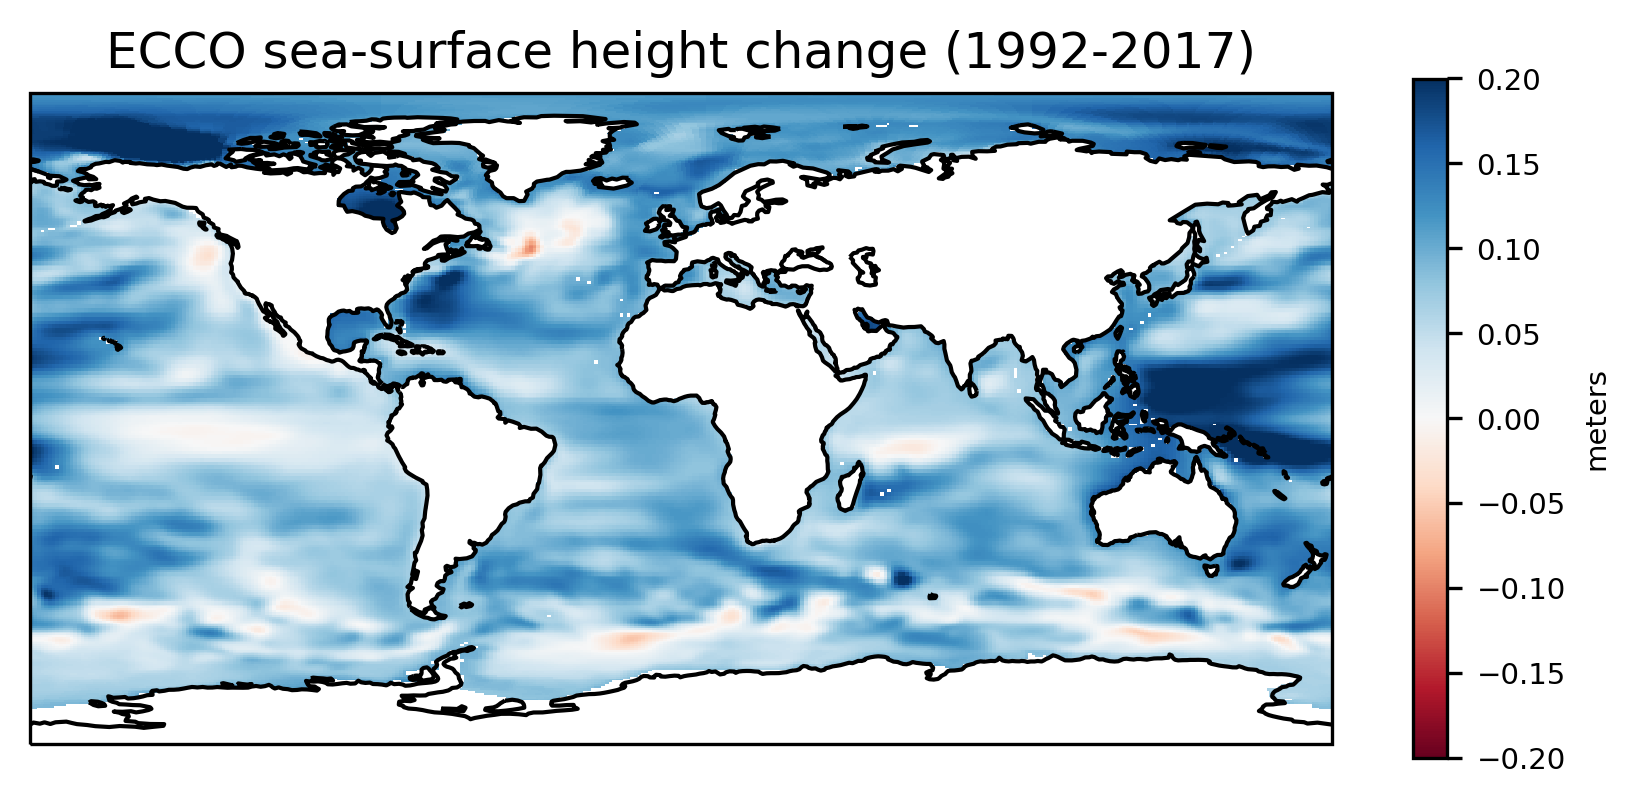

In [6]:
# Plot
fig = plt.figure(figsize=(7,3), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
pc = ax.pcolormesh(lon, lat, SSH_2017_minus_1992, transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-0.20, vmax=+0.20)

c = plt.colorbar(pc)
c.ax.tick_params(labelsize=7)
c.set_label('meters', size=7)

ax.coastlines()

ax.set_title('ECCO sea-surface height change (1992-2017)')

### Create a COG

This is a two-step process. First, write a geotiff for the SSH change array. Second, convert the geotiff into a COG.

In [7]:
# Get geoTransform for the tif
minX = lon[0]  - (lon[1] - lon[0])/2
maxX = lon[-1] + (lon[1] - lon[0])/2
minY = lat[0]  - (lat[1] - lat[0])/2
maxY = lat[-1] + (lat[1] - lat[0])/2

extent = minX, maxX, minY, maxY
left, right, bottom, top = extent

height, width = SSH_2017_minus_1992.shape
xstep = (right-left) / width
ystep = (bottom-top) / height

geoTransform = (left, xstep, 0, top, 0, ystep)

# Write the tif
import raster
raster.writeArrayAsRasterBand('SSH_2017_minus_1992.tif',geoTransform,np.flipud(SSH_2017_minus_1992),-9999.,epsg=4326)


In [8]:
# Create the COG using rio-cogeo (https://github.com/cogeotiff/rio-cogeo)
!rio cogeo create SSH_2017_minus_1992.tif SSH_2017_minus_1992.cog.tif

/srv/conda/envs/notebook/lib/python3.9/site-packages/rio_cogeo/cogeo.py:192: IncompatibleBlockRasterSize: Block Size are bigger than raster sizes. Setting blocksize to 256
  warnings.warn(
Reading input: /home/jovyan/veda-data-processing/ECCO_NetCDF_to_COG/SSH_2017_minus_1992.tif
  [####################################]  100%
Adding overviews...
Updating dataset tags...
Writing output to: /home/jovyan/veda-data-processing/ECCO_NetCDF_to_COG/SSH_2017_minus_1992.cog.tif


In [9]:
# Check the validity of the COG using validate_cloud_optimized_geotiff.py
# NOTE: This can be downloaded from https://github.com/rouault/cog_validator

#!/home/jovyan/Software/cog_validator/validate_cloud_optimized_geotiff.py SSH_2017_minus_1992.cog.tif